In [1]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rtree
!pip install geopandas
!pip install osmnx
!pip install pygeos
!pip install matplotlib==3.1.3 
!pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.7 MB/s 
     |████████████████████████████████| 16.7 MB 346 kB/s 
     |████████████████████████████████| 6.3 MB 50.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 2.8 MB/s 
     |████████████████████████████████| 11.2 MB 34.9 MB/s 
     |████████████████████████████████| 62 kB 993 kB/s 
     |████████████████████████████████| 944 kB 47.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 5.5 MB/s 


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import pytz
import contextily

from pygeos import predicates
from scipy.spatial import distance

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Emission Data

In [ ]:
#Read in data
nonpoint = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Data/San_Francisco/nonpoint_pm25.geojson")
nonroad=gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Data/San_Francisco/nonroad_pm25.geojson")
onroad=gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Data/San_Francisco/onroad_pm25.geojson")
point=gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Data/San_Francisco/point_pm25.geojson")

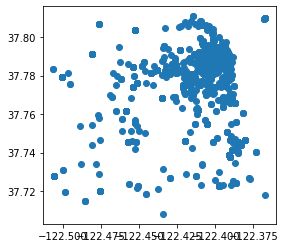

In [ ]:
point.plot()

# EJ Screen Data

In [4]:
# Use year and geoid
year = '2021'
geoid = '41860' # San Francisco Metro

# Load in Core Based Statistical Areas (CBSAs)
cbsa = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Data/shared_data_LUR/data/boundaries/Core Based Statistical Areas (CBSAs)/cb_2018_us_cbsa_500k.shp')
print(cbsa.crs)

# Plot area based on id number
region =  cbsa.loc[cbsa['GEOID'] == geoid]
region_proj = region.to_crs('ESRI:102003')

region_proj_buffer=region_proj.buffer(200).to_frame('geometry')

epsg:4269


In [5]:
#Load in census block group
us_cbg=gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Data/cb_2021_06_bg_500k/cb_2021_06_bg_500k.shp")
cbg_proj = us_cbg.to_crs('ESRI:102003')

san_fran_cbg= cbg_proj.sjoin(region_proj_buffer,predicate="within")


In [6]:
# Drop column called index_right
san_fran_cbg=san_fran_cbg.drop(columns=['index_right'])

In [7]:
san_fran_cbg

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry
2,06,001,428302,3,1500000US060014283023,060014283023,3,Block Group 3,BG,647392,130654,"POLYGON ((-2262236.938 342217.089, -2261881.37..."
3,06,041,130204,1,1500000US060411302041,060411302041,1,Block Group 1,BG,877599,3843644,"POLYGON ((-2280211.649 363251.776, -2279823.69..."
6,06,075,061401,3,1500000US060750614013,060750614013,3,Block Group 3,BG,136709,0,"POLYGON ((-2274663.566 346845.449, -2274339.16..."
9,06,075,016000,2,1500000US060750160002,060750160002,2,Block Group 2,BG,73076,0,"POLYGON ((-2275423.590 350271.174, -2275284.79..."
33,06,001,421800,2,1500000US060014218002,060014218002,2,Block Group 2,BG,252272,0,"POLYGON ((-2260764.115 357329.693, -2260704.36..."
...,...,...,...,...,...,...,...,...,...,...,...,...
25559,06,001,433500,4,1500000US060014335004,060014335004,4,Block Group 4,BG,288774,0,"POLYGON ((-2256211.035 332615.359, -2255786.11..."
25562,06,013,304007,2,1500000US060133040072,060133040072,2,Block Group 2,BG,4519321,5022,"POLYGON ((-2206050.177 345391.441, -2206006.46..."
25567,06,075,021200,1,1500000US060750212001,060750212001,1,Block Group 1,BG,102796,0,"POLYGON ((-2277568.824 347502.831, -2277281.37..."
25575,06,075,016101,1,1500000US060750161011,060750161011,1,Block Group 1,BG,61477,0,"POLYGON ((-2276485.792 349969.265, -2276198.14..."


In [8]:
# Bring in EJ Screen data
ej_screen=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/EJ Screen/EJSCREEN_2021_USPR_Tracts.csv")
ej_screen["P_PM25_D2"]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (154,155,156,157) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0        48.309088
1        68.838576
2        54.929088
3        23.455354
4        10.812171
           ...    
73996          NaN
73997          NaN
73998          NaN
73999          NaN
74000          NaN
Name: P_PM25_D2, Length: 74001, dtype: float64

In [9]:
#Match the CRS and merge the data
ej_screen.crs = "EPSG:4269"

# Edit GEOID row to match for each dataset
san_fran_cbg['GEOID']=san_fran_cbg.apply(lambda x: x['GEOID'][1:11], axis = 1)

# Convert column to string
ej_screen['ID'] = ej_screen['ID'].astype(str)

merged_data = san_fran_cbg.merge(ej_screen, left_on="GEOID", right_on= "ID")
merged_data

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,...,T_PM25,T_PM25_D2,T_UST,T_UST_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,06,001,428302,3,1500000US060014283023,6001428302,3,Block Group 3,BG,647392,...,12.9 ug/m3 (96%ile),42%ile,0.58 facilities/sq km area (29%ile),44%ile,2234425.0,474770.0,0,0,8635.683618,4.339935e+06
1,06,001,428302,1,1500000US060014283021,6001428302,1,Block Group 1,BG,727957,...,12.9 ug/m3 (96%ile),42%ile,0.58 facilities/sq km area (29%ile),44%ile,2234425.0,474770.0,0,0,8635.683618,4.339935e+06
2,06,001,428302,2,1500000US060014283022,6001428302,2,Block Group 2,BG,856061,...,12.9 ug/m3 (96%ile),42%ile,0.58 facilities/sq km area (29%ile),44%ile,2234425.0,474770.0,0,0,8635.683618,4.339935e+06
3,06,075,016000,2,1500000US060750160002,6075016000,2,Block Group 2,BG,73076,...,12.2 ug/m3 (94%ile),64%ile,12 facilities/sq km area (92%ile),74%ile,157523.0,0.0,0,0,2243.474430,2.526073e+05
4,06,075,016000,1,1500000US060750160001,6075016000,1,Block Group 1,BG,84447,...,12.2 ug/m3 (94%ile),64%ile,12 facilities/sq km area (92%ile),74%ile,157523.0,0.0,0,0,2243.474430,2.526073e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644,06,041,118100,2,1500000US060411181002,6041118100,2,Block Group 2,BG,2586790,...,11 ug/m3 (91%ile),27%ile,0.61 facilities/sq km area (29%ile),36%ile,4056498.0,0.0,0,0,14677.179990,6.536891e+06
2645,06,041,118100,1,1500000US060411181001,6041118100,1,Block Group 1,BG,1425521,...,11 ug/m3 (91%ile),27%ile,0.61 facilities/sq km area (29%ile),36%ile,4056498.0,0.0,0,0,14677.179990,6.536891e+06
2646,06,075,980900,1,1500000US060759809001,6075980900,1,Block Group 1,BG,3602295,...,12.3 ug/m3 (94%ile),59%ile,8 facilities/sq km area (87%ile),61%ile,3585240.0,260707.0,0,0,11945.170040,6.161331e+06
2647,06,081,984300,1,1500000US060819843001,6081984300,1,Block Group 1,BG,7955702,...,11.4 ug/m3 (92%ile),59%ile,0 facilities/sq km area (4%ile),60%ile,7920247.0,3591281.0,0,3,17490.458770,1.838044e+07


In [10]:
max=merged_data["P_PM25_D2"].max()

In [11]:
merged_data_gdf = gpd.GeoDataFrame(merged_data, geometry='geometry', crs='ESRI:102003')      

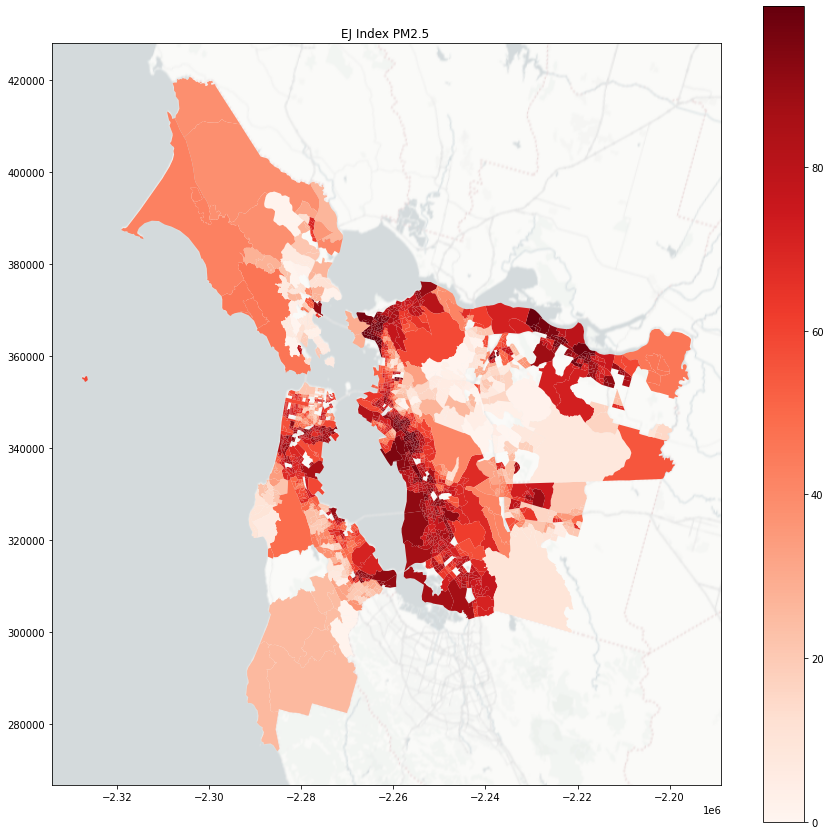

In [21]:
#Plot our results
fig, ax = plt.subplots(figsize=(15, 15))

merged_data_gdf.plot(column=('P_PM25_D2'),markersize=1, ax=ax, cmap="Reds")

# Add basemap
contextily.add_basemap(ax=ax, crs=san_fran_cbg.crs, source=contextily.providers.CartoDB.PositronNoLabels)

#ax.set_axis_off(); # Remove axes

ax.set_title("EJ Index PM2.5 ", fontsize=12)

sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max))
sm.set_array([])
plt.colorbar(sm)


# Testing and Comparison

In [12]:
# EJ Screen Data
merged_data_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,...,T_PM25,T_PM25_D2,T_UST,T_UST_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,06,001,428302,3,1500000US060014283023,6001428302,3,Block Group 3,BG,647392,...,12.9 ug/m3 (96%ile),42%ile,0.58 facilities/sq km area (29%ile),44%ile,2234425.0,474770.0,0,0,8635.683618,4.339935e+06
1,06,001,428302,1,1500000US060014283021,6001428302,1,Block Group 1,BG,727957,...,12.9 ug/m3 (96%ile),42%ile,0.58 facilities/sq km area (29%ile),44%ile,2234425.0,474770.0,0,0,8635.683618,4.339935e+06
2,06,001,428302,2,1500000US060014283022,6001428302,2,Block Group 2,BG,856061,...,12.9 ug/m3 (96%ile),42%ile,0.58 facilities/sq km area (29%ile),44%ile,2234425.0,474770.0,0,0,8635.683618,4.339935e+06
3,06,075,016000,2,1500000US060750160002,6075016000,2,Block Group 2,BG,73076,...,12.2 ug/m3 (94%ile),64%ile,12 facilities/sq km area (92%ile),74%ile,157523.0,0.0,0,0,2243.474430,2.526073e+05
4,06,075,016000,1,1500000US060750160001,6075016000,1,Block Group 1,BG,84447,...,12.2 ug/m3 (94%ile),64%ile,12 facilities/sq km area (92%ile),74%ile,157523.0,0.0,0,0,2243.474430,2.526073e+05


In [13]:
pop_weighted_gdf=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Population Weighted GDF.csv")
pop_weighted_gdf.head()

,Unnamed: 0,GEOID,PM 2.5 Average,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,NAME,NAMELSAD,...,AMP4M003,AMR9M001,geometry_y,Minority Population,Pop Weighted Exposure,White Pop Weighted Exposure,Black Pop Weighted Exposure,Hispanic Pop Weighted Exposure,Asian Pop Weighted Exposure,Minority Pop Weighted Exposure
0,0,60014001001,8.132299,6,1,400100,1,1500000US060014001001,1,Block Group 1,...,26,50673515.0,NaN,502.0,0.002958,5.886778,0.375045,0.137675,1.182103,2.383195
1,1,60014001002,8.151097,6,1,400100,2,1500000US060014001002,2,Block Group 2,...,75,59758611.0,NaN,359.0,0.002288,6.529509,0.092486,0.591910,1.079003,2.213497
2,2,60014002001,8.199172,6,1,400200,1,1500000US060014002001,1,Block Group 1,...,42,19930932.0,NaN,264.0,0.001637,6.419777,0.087225,0.523351,0.436126,2.302746
3,3,60014002002,8.249708,6,1,400200,2,1500000US060014002002,2,Block Group 2,...,68,17681213.0,NaN,480.0,0.001827,5.267790,0.268926,0.814688,1.336722,3.796606
4,4,60014003001,8.300243,6,1,400300,1,1500000US060014003001,1,Block Group 1,...,66,43154972.0,NaN,531.0,0.002126,5.148078,0.000000,0.502419,2.732335,3.654585


In [14]:
#Match the CRS and merge the data
merged_data_gdf.crs = "EPSG:4269"

# Edit GEOID row to match for each dataset
pop_weighted_gdf['GEOID'] = pop_weighted_gdf['GEOID'].astype(str)
pop_weighted_gdf['GEOID']=pop_weighted_gdf.apply(lambda x: x['GEOID'][0:10], axis = 1)

# Convert column to string
#pop_weighted_gdf['ID'] = pop_weighted_gdf['ID'].astype(str)

merged_data_for_comparison = merged_data_gdf.merge(pop_weighted_gdf, left_on="GEOID", right_on= "GEOID")
merged_data_normalized= merged_data_for_comparison[["Minority Pop Weighted Exposure"]]


In [15]:
# Normalize data
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler([0,max])
 
df_scaled = scaler.fit_transform(merged_data_normalized.to_numpy())
df_scaled = pd.DataFrame(df_scaled)


In [16]:
merged_data_for_comparison["Normalized Minority Pop Weighted Exposure"]=df_scaled[0]

In [17]:
roads = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Data/Roads/tl_2021_06_prisecroads.shp')
roads_proj = roads.to_crs('ESRI:102003')

region_roads_proj = gpd.clip(roads_proj, region_proj)

In [18]:
us_rails = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Data/Rail/tl_2021_us_rails.shp')
us_rails_proj = us_rails.to_crs('ESRI:102003')
region_rails_proj = gpd.clip(us_rails_proj,region_proj)

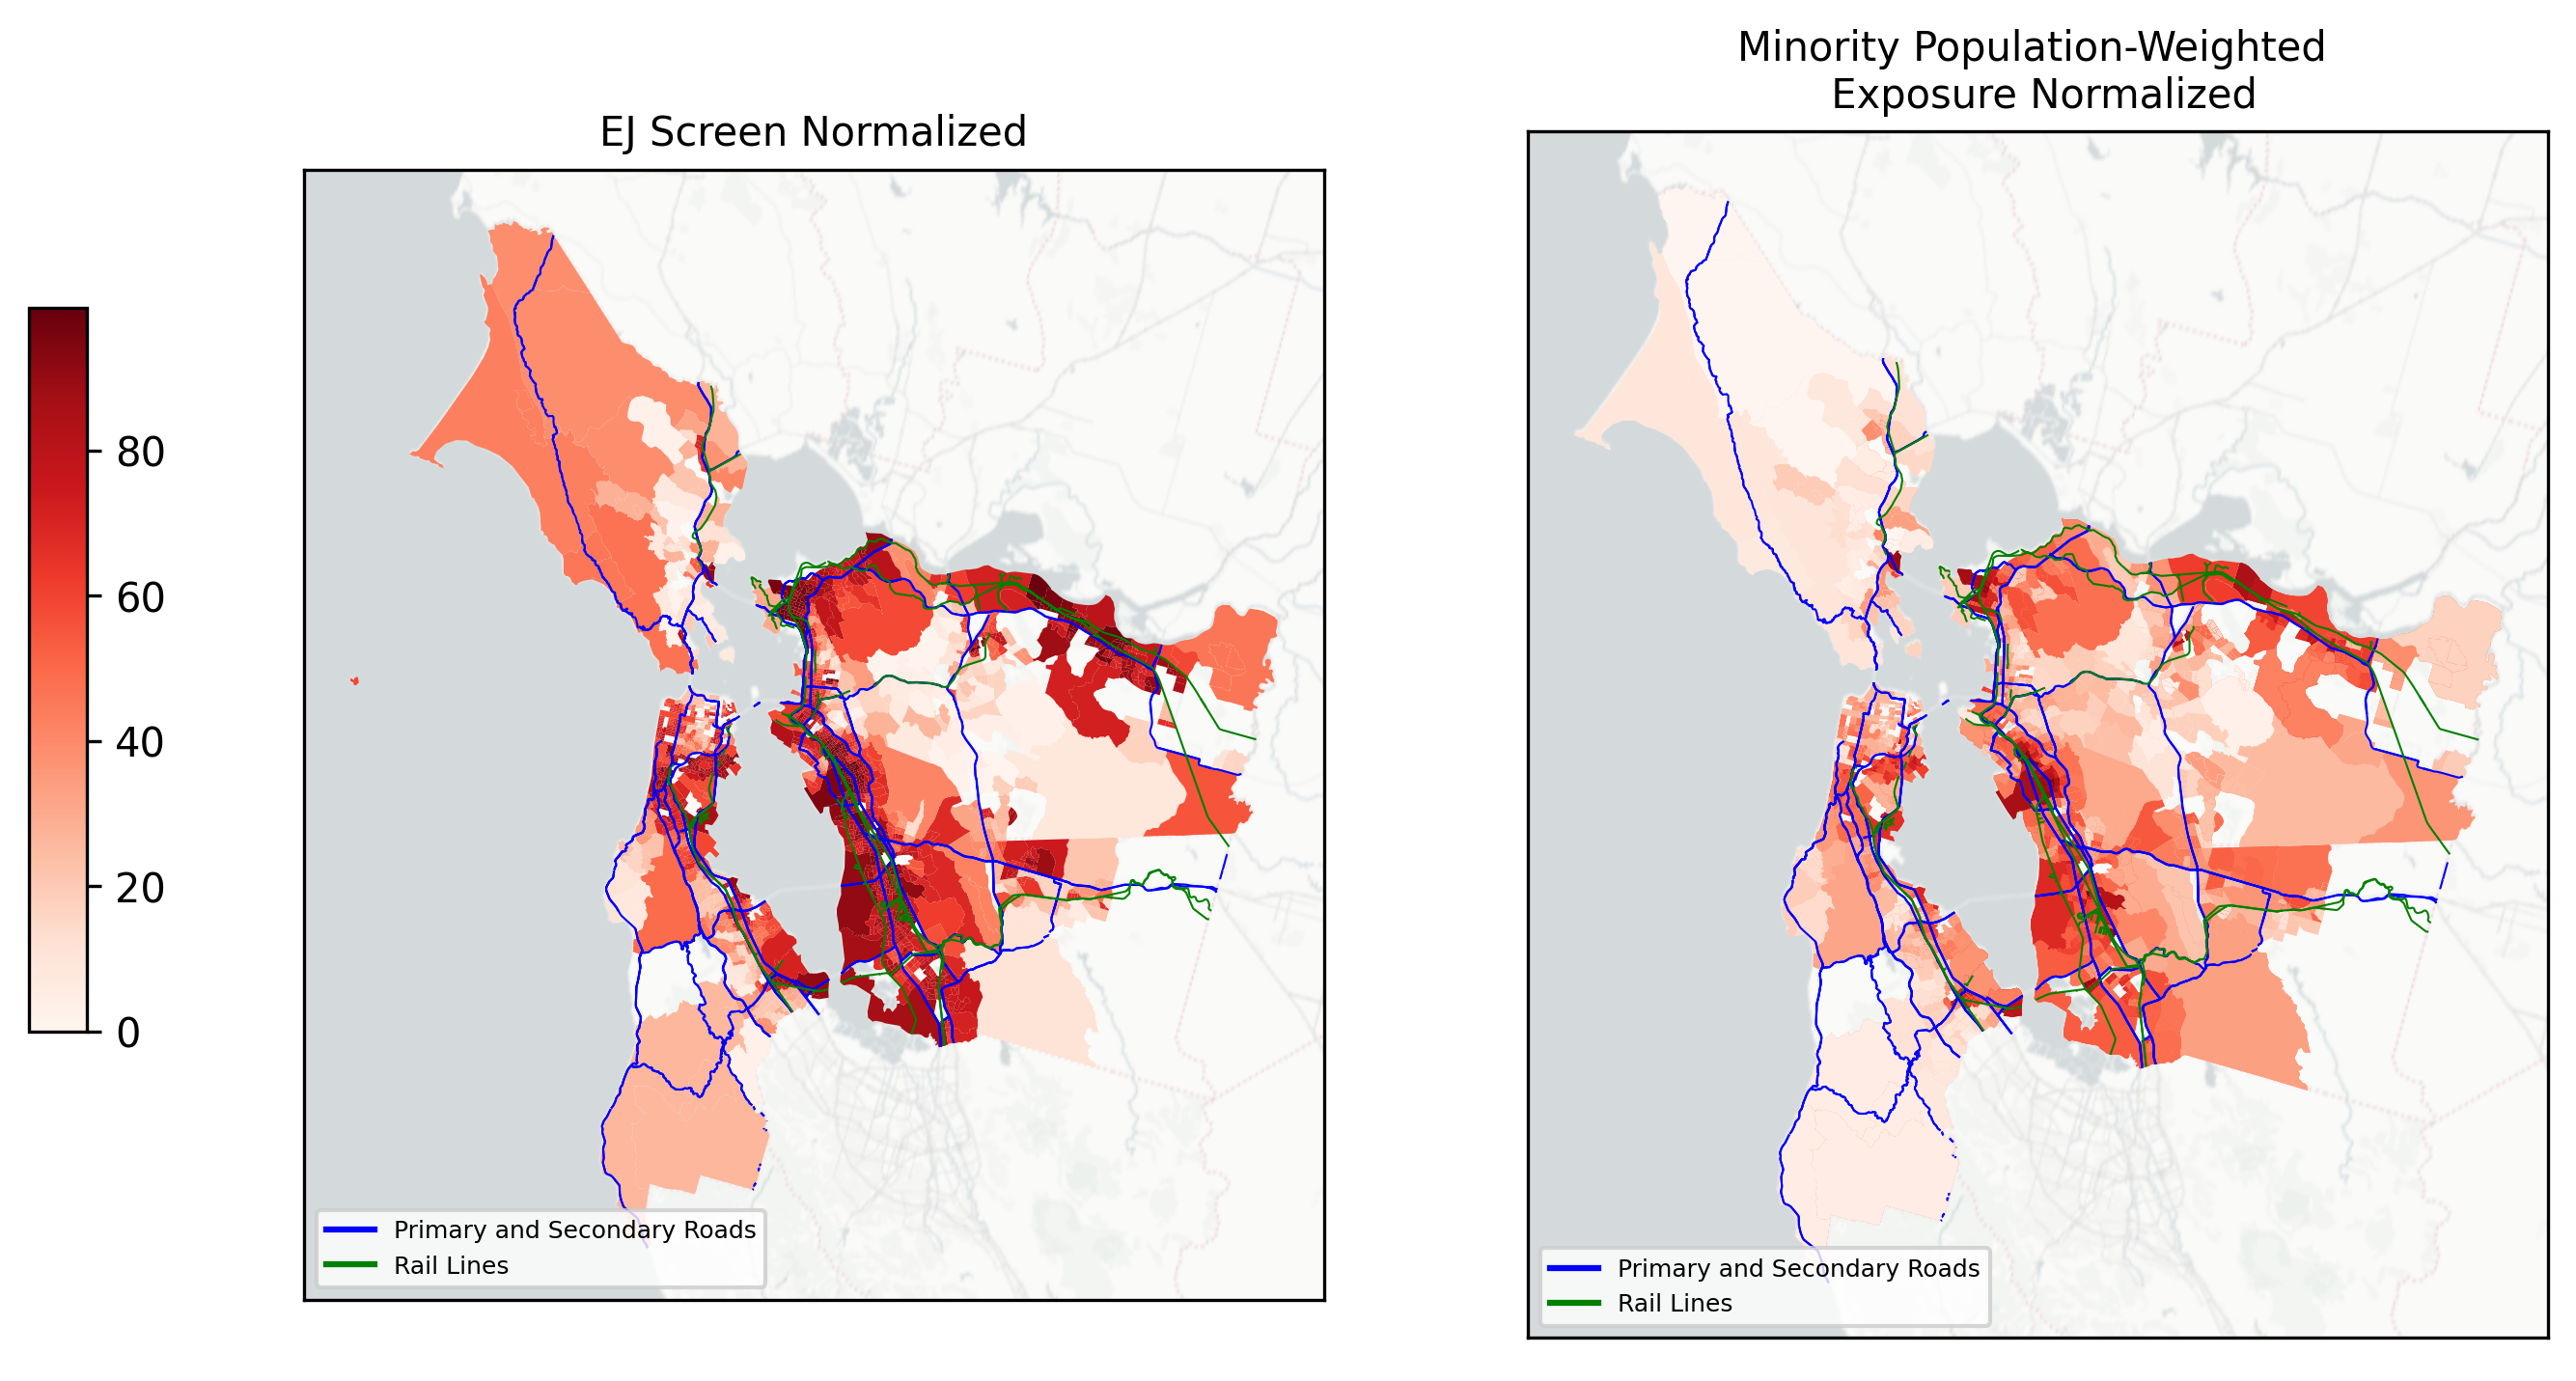

In [27]:
#Plot our results
from matplotlib.lines import Line2D

fig, (ax1,ax2) = plt.subplots(1,2, sharey='row', figsize=(10, 10), dpi=300)

# Figure 1- EJ Data Calculated Data
merged_data_gdf.plot(column=('P_PM25_D2'),markersize=1, ax=ax1, cmap="Reds", vmin=0, vmax=100)
region_roads_proj.plot(ax=ax1, linewidth=0.5, markersize=0, color="blue")
region_rails_proj.plot(ax=ax1, linewidth=0.5, markersize=0, color="green")

ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)


line = Line2D([0], [0], label='Primary and Secondary Roads', color='blue')
line2 = Line2D([0], [0], label='Rail Lines', color='green')
ax1.legend(handles=[line, line2], loc='lower left',
          prop={'size': 6})

# Add basemap
contextily.add_basemap(ax=ax1, crs=san_fran_cbg.crs, source=contextily.providers.CartoDB.PositronNoLabels)
ax1.set_title("EJ Screen Normalized", fontsize=10)

# Figure 2- Generated data
merged_data_for_comparison.plot(column=("Normalized Minority Pop Weighted Exposure"),markersize=1, ax=ax2, cmap="Reds",vmin=0, vmax=100)
# Add basemap
contextily.add_basemap(ax=ax2, crs=san_fran_cbg.crs, source=contextily.providers.CartoDB.PositronNoLabels)
ax2.set_title("Minority Population-Weighted \n Exposure Normalized", fontsize=10)
region_roads_proj.plot(ax=ax2, linewidth=0.5, markersize=0, color="blue")
region_rails_proj.plot(ax=ax2, linewidth=0.5, markersize=0, color="green")

ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)


ax2.legend(handles=[line, line2], loc='lower left',
          prop={'size': 6})

cb_ax = fig.add_axes([0.03, 0.40, 0.02, 0.25])
cbar=fig.colorbar(sm, cax=cb_ax)
cbar.ax.tick_params(labelsize=10) 



/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s = str(s)


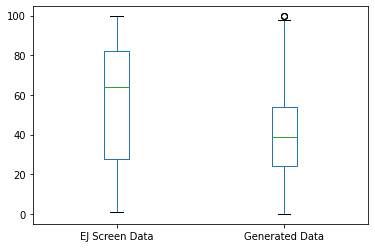

In [ ]:
merged_data_for_comparison['EJ Screen Data']=merged_data_for_comparison["P_PM25_D2"]
merged_data_for_comparison['Generated Data']=merged_data_for_comparison["Normalized Minority Pop Weighted Exposure"]
merged_data_for_comparison.boxplot(column=['EJ Screen Data', 'Generated Data'], grid=False)
plt.show()

In [ ]:
# SciPy v1.7.1
import scipy.stats as stats
# perform two-sided test
stats.ttest_ind(a=merged_data_for_comparison['EJ Screen Data'].dropna(), b=merged_data_for_comparison['Generated Data'].dropna(),
                equal_var=True)


Ttest_indResult(statistic=43.65305019426106, pvalue=0.0)